## Buka data

In [1]:
import utility as ut
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
# Load data
DIRECTORY = "data/"
datasets = ut.load_excel_data(DIRECTORY)

In [3]:
DURATION = 15  # duration in seconds
DT = 0.02  # time increment in seconds
# Create a time array
time_array = np.arange(0, DURATION + DT, DT)
NUM_STEPS = len(time_array)
print(NUM_STEPS)

751


In [4]:
interpolated_datasets = []
for i in range(len(datasets)):
    new_trolley_position = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["trolley_position"]
    )
    new_cable_length = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["cable_length"]
    )
    new_sway_angle = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["sway_angle"]
    )
    new_trolley_motor_pwm = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["pwm_trolley_motor"]
    )
    new_hoist_motor_pwm = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["pwm_hoist_motor"]
    )
    interpolated_df = {
        "trolley_position": new_trolley_position,
        "cable_length": new_cable_length,
        "sway_angle": new_sway_angle,
        "trolley_motor_pwm": new_trolley_motor_pwm,
        "hoist_motor_pwm": new_hoist_motor_pwm,
    }

    interpolated_datasets.append(interpolated_df)

print(len(interpolated_datasets))


39


In [5]:
def create_hankel_matrix(data_dict, L):
    """
    Create a Hankel matrix from time-series data.

    Parameters:
    - data_dict: Dictionary with keys as variable names (inputs/outputs) and values as lists/arrays of time-series data.
    - L: Lag parameter (number of past steps to include).
    
    Returns:
    - H: The constructed Hankel matrix.
    """
    # Convert dictionary values to a single stacked array (row-wise)
    data_matrix = np.vstack([np.array(data_dict[key]) for key in data_dict])
    
    # Get the total number of time steps (T)
    T = data_matrix.shape[1]
    
    # Compute number of columns for Hankel matrix
    num_cols = T - L + 1
    if num_cols <= 0:
        raise ValueError("Not enough data points for the given L value!")

    # Construct Hankel matrix
    hankel_rows = []
    for i in range(L):
        hankel_rows.append(data_matrix[:, i:i+num_cols])  # Take L past steps

    H = np.vstack(hankel_rows)  # Stack vertically
    return H

In [6]:
L = 5  # Number of past steps to include
N = 5  # Number of future steps to predict
T = NUM_STEPS # Number of time steps

In [7]:
H_y_mosaic = []
H_u_mosaic = []

for data in interpolated_datasets:
    dict_y = {"x": data["trolley_position"], "l": data["cable_length"], "theta": data["sway_angle"]}
    dict_u = {"u1": data["trolley_motor_pwm"], "u2": data["hoist_motor_pwm"]}
    H_y = create_hankel_matrix(dict_y, L)
    H_u = create_hankel_matrix(dict_u, L)
    H_y_mosaic.append(H_y)
    H_u_mosaic.append(H_u)

H_y_mosaic = np.hstack(H_y_mosaic)
H_u_mosaic = np.hstack(H_u_mosaic)

H_mosaic = np.vstack([H_y_mosaic, H_u_mosaic])

print("H_mosaic shape:", H_mosaic.shape)

H_mosaic shape: (25, 29133)


In [8]:
xi_list = []
zeta_list = []

for data in interpolated_datasets:
    for k in range (L, T - N):
        past_outputs = np.column_stack([data["trolley_position"][k-L:k], data["cable_length"][k-L:k], data["sway_angle"][k-L:k]])
        past_inputs = np.column_stack([data["trolley_motor_pwm"][k-L:k], data["hoist_motor_pwm"][k-L:k]])

        xi = np.column_stack([past_outputs, past_inputs]).reshape(-1, 1)
        xi_list.append(xi)

        future_outputs = np.column_stack([data["trolley_position"][k:k+N], data["cable_length"][k:k+N], data["sway_angle"][k:k+N]])
        future_inputs = np.column_stack([data["trolley_motor_pwm"][k:k+N], data["hoist_motor_pwm"][k:k+N]])

        zeta = np.column_stack([future_outputs, future_inputs]).reshape(-1, 1)
        zeta_list.append(zeta)



In [9]:
Z_matrix = np.hstack(zeta_list)
print("Z_matrix shape:", Z_matrix.shape)

print("xi_list shape:", np.array(xi_list).shape)
print("zeta_list shape:", np.array(zeta_list).shape)

Z_matrix shape: (25, 28899)
xi_list shape: (28899, 25, 1)
zeta_list shape: (28899, 25, 1)


In [10]:
def save_matrices(P, Phi, filename="matrices.npz"):
    """
    Saves P and Phi matrices to a compressed .npz file.

    Parameters:
    - P: Storage function matrix.
    - Phi: Supply rate function matrix.
    - filename: The filename to save (default: "matrices.npz").
    """
    np.savez_compressed(filename, P=P, Phi=Phi)
    print(f"Saved matrices to {filename}")


In [11]:
def find_P_and_Phi(H, Z):
    """
    Solves the LMI to find P and Phi.

    Parameters:
    - H: Hankel matrix (from create_hankel_matrix).
    - Z: Z matrix (from create_Z_vector).
    - n_states: Number of states in the extended system.

    Returns:
    - P: Storage function matrix.
    - Phi: Supply rate function matrix.
    """
    # Get matrix dimensions
    n_samples = Z.shape[1] - 1  # Number of state transitions

    print("n_samples: ", n_samples)

    # Extract Xi0 and Xi1 from Hankel matrix
    Xi0 = H[:, :-1]  # All but last column
    Xi1 = H[:, 1:]   # All but first column

    print("Shape Xi0: ", Xi0.shape)
    print("Shape Xi1: ", Xi1.shape)

    print("Shape Z: ", Z.shape)

    # Define optimization variables
    P = cp.Variable((H.shape[0], H.shape[0]), symmetric=True)
    Phi = cp.Variable((Z.shape[0], Z.shape[0]), symmetric=True)

    # Define LMI constraint: Xi1^T P Xi1 - Xi0^T P Xi0 - Z^T Phi Z <= 0
    LMI_constraints = []
    for i in range(n_samples):
        Xi1_i = Xi1[:, i].reshape(-1, 1)
        Xi0_i = Xi0[:, i].reshape(-1, 1)
        Z_i = Z[:, i].reshape(-1, 1)
        
        LMI_constraints.append(
            Xi1_i.T @ P @ Xi1_i - Xi0_i.T @ P @ Xi0_i - Z_i.T @ Phi @ Z_i << 0
        )

    # Ensure P is positive semi-definite
    LMI_constraints.append(P >> 0)
    # LMI_constraints.append(Phi >> 0)

    # Define the optimization problem
    problem = cp.Problem(cp.Minimize(0), LMI_constraints)

    # Solve the LMI problem
    problem.solve(solver=cp.MOSEK, verbose=True)

    if problem.status in ["infeasible", "unbounded"]:
        raise ValueError("LMI problem is infeasible. Check your data!")

    return P.value, Phi.value


In [12]:
P, Phi = find_P_and_Phi(H_mosaic, Z_matrix)
print(P)
print(Phi)

save_matrices(P, Phi, filename="matrices.npz")

n_samples:  28898
Shape Xi0:  (25, 29132)
Shape Xi1:  (25, 29132)
Shape Z:  (25, 28899)
                                     CVXPY                                     
                             v1.6.1.dev0+0.1777eb0                             
(CVXPY) Feb 22 01:31:12 PM: Your problem has 1250 variables, 29523 constraints, and 0 parameters.
(CVXPY) Feb 22 01:31:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 22 01:31:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 22 01:31:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 22 01:31:16 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
----------------------------------------------------------

/home/icodes/.local/lib/python3.10/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/home/icodes/.local/lib/python3.10/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/home/icodes/.local/lib/python3.10/site-packages/mosek/__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putconboundlist: Incorrect array format causing data to be copied");


(CVXPY) Feb 22 02:27:27 PM: Problem
(CVXPY) Feb 22 02:27:27 PM:   Name                   :                 
(CVXPY) Feb 22 02:27:27 PM:   Objective sense        : maximize        
(CVXPY) Feb 22 02:27:27 PM:   Type                   : CONIC (conic optimization problem)
(CVXPY) Feb 22 02:27:27 PM:   Constraints            : 650             
(CVXPY) Feb 22 02:27:27 PM:   Affine conic cons.     : 0               
(CVXPY) Feb 22 02:27:27 PM:   Disjunctive cons.      : 0               
(CVXPY) Feb 22 02:27:27 PM:   Cones                  : 0               
(CVXPY) Feb 22 02:27:27 PM:   Scalar variables       : 0               
(CVXPY) Feb 22 02:27:27 PM:   Matrix variables       : 28899 (scalarized: 29223)
(CVXPY) Feb 22 02:27:27 PM:   Integer variables      : 0               
(CVXPY) Feb 22 02:27:27 PM: 
(CVXPY) Feb 22 02:27:27 PM: Optimizer started.
(CVXPY) Feb 22 02:27:30 PM: Presolve started.
(CVXPY) Feb 22 02:27:30 PM: Linear dependency checker started.
(CVXPY) Feb 22 02:27:30 PM: Line

In [13]:
def load_matrices(filename="matrices.npz"):
    """
    Loads P and Phi matrices from a .npz file.

    Parameters:
    - filename: The filename to load (default: "matrices.npz").

    Returns:
    - P: Loaded storage function matrix.
    - Phi: Loaded supply rate function matrix.
    """
    data = np.load(filename)
    P = data["P"]
    Phi = data["Phi"]
    print(f"Loaded matrices from {filename}")
    return P, Phi

In [14]:
P, Phi = load_matrices(filename="matrices.npz")

Loaded matrices from matrices.npz


In [15]:
def dissipativity_inequality(P, Phi, xi0, xi1, Z):
    """
    Computes the dissipativity inequality for fault detection.

    Parameters:
    - P: Storage function matrix.
    - Phi: Supply rate function matrix.
    - xi0: Column vector for xi(k).
    - xi1: Column vector for xi(k+1).
    - Z: Column vector for Z(k).

    Returns:
    - True if the dissipativity inequality is satisfied, False otherwise.
    """
    # Compute the left-hand side of the inequality
    lhs = xi1.T @ P @ xi1 - xi0.T @ P @ xi0

    # Compute the right-hand side of the inequality
    rhs = Z.T @ Z

    # Check if the inequality is satisfied
    return lhs - rhs

In [16]:
TF = 5 # window of samples observed for detecting faults

In [17]:
xi_list = []
zeta_list = []
Y_array = []
J_array = []
Y_square_array = []

for data in interpolated_datasets:
    for k in range (L, T - N):
        k -= 1
        past_outputs = np.column_stack([data["trolley_position"][k-L:k], data["cable_length"][k-L:k], data["sway_angle"][k-L:k]])
        past_inputs = np.column_stack([data["trolley_motor_pwm"][k-L:k], data["hoist_motor_pwm"][k-L:k]])

        xi = np.column_stack([past_outputs, past_inputs]).reshape(-1, 1)
        xi_list.append(xi)

        future_outputs = np.column_stack([data["trolley_position"][k:k+N], data["cable_length"][k:k+N], data["sway_angle"][k:k+N]])
        future_inputs = np.column_stack([data["trolley_motor_pwm"][k:k+N], data["hoist_motor_pwm"][k:k+N]])

        zeta = np.column_stack([future_outputs, future_inputs]).reshape(-1, 1)
        zeta_list.append(zeta)

        if k > L:
            Y = dissipativity_inequality(P, Phi, xi_list[k-L], xi_list[k-L+1], zeta_list[k-L])
            Y_array.append(Y)
            Y_square_array.append(Y_array[k-L-1]**2)

            if len(Y_square_array) > TF:
                J_array.append(np.sqrt(np.sum(Y_square_array[k-TF-L:k-L])))


In [18]:
# Calculate the mean of the fault detection metric
J_mean = np.mean(J_array)
print(f"Mean of the fault detection metric: {J_mean}")

# Calculate the standard deviation of the fault detection metric
J_std = np.std(J_array)
print(f"Standard deviation of the fault detection metric: {J_std}")

# Determine the threshold for fault detection
threshold = J_mean + 3 * J_std
print(f"Threshold for fault detection: {threshold}")

Mean of the fault detection metric: 1488666.0576827058
Standard deviation of the fault detection metric: 2640796.7367284345
Threshold for fault detection: 9411056.267868008


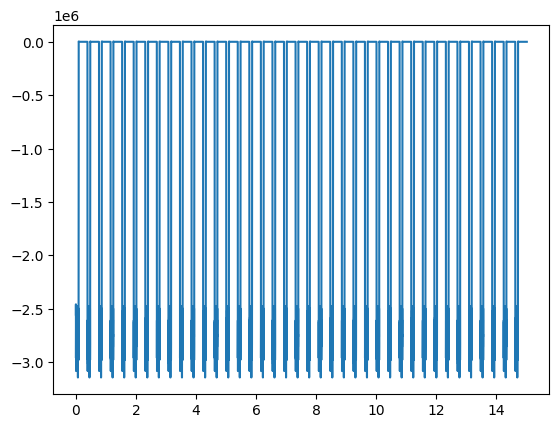

In [19]:
plt.plot(np.linspace(0, DURATION + DT, len(Y_array)), np.array(Y_array).flatten())

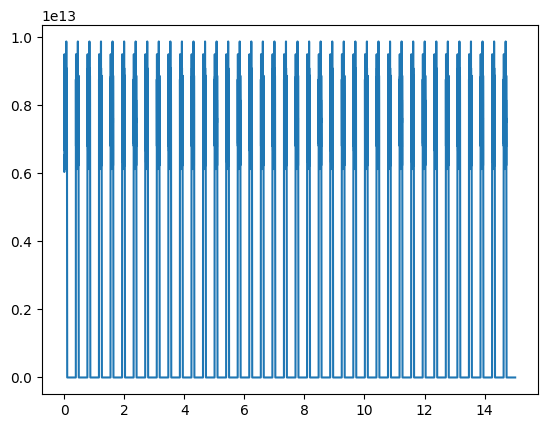

In [20]:
plt.plot(np.linspace(0, DURATION + DT, len(Y_square_array)), np.array(Y_square_array).flatten())

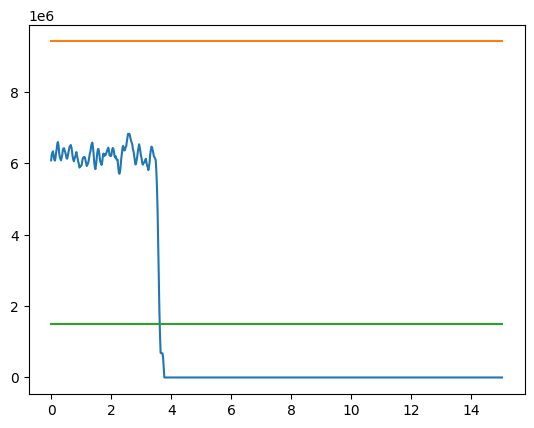

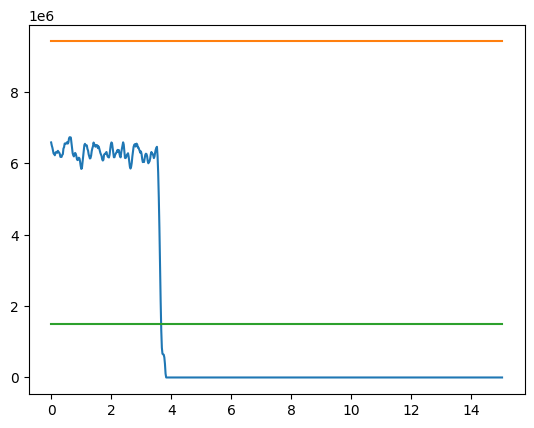

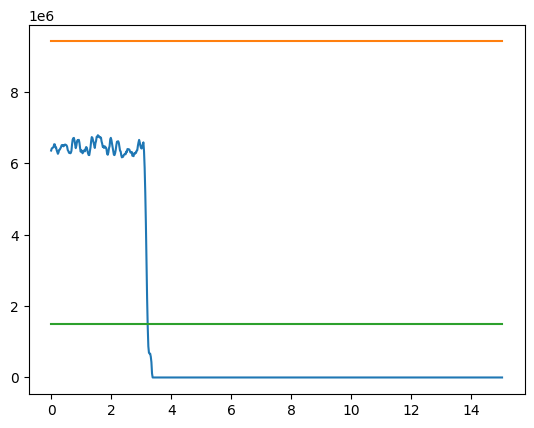

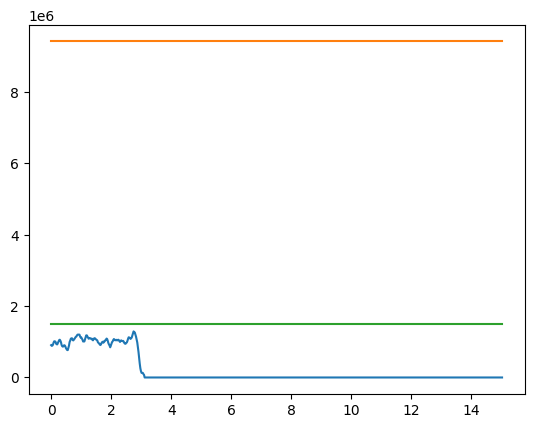

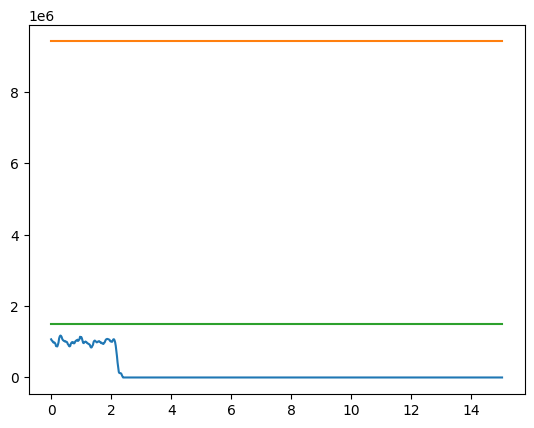

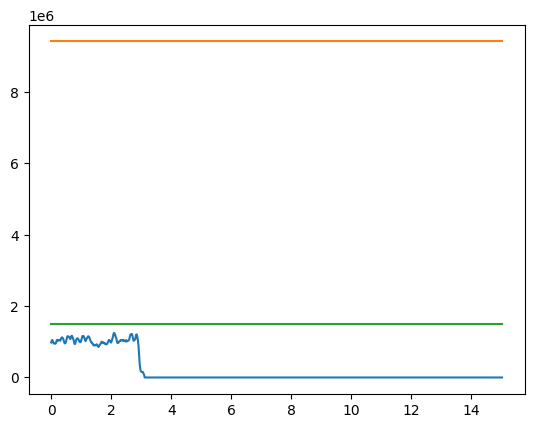

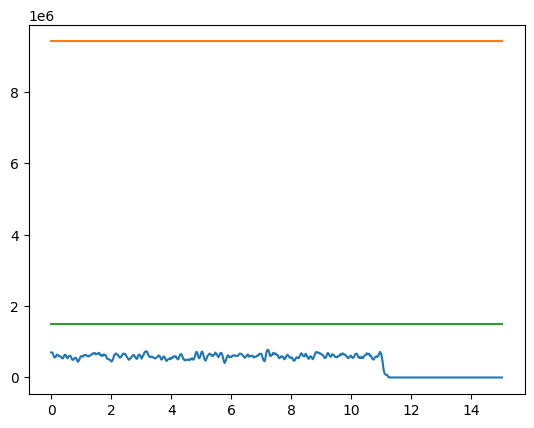

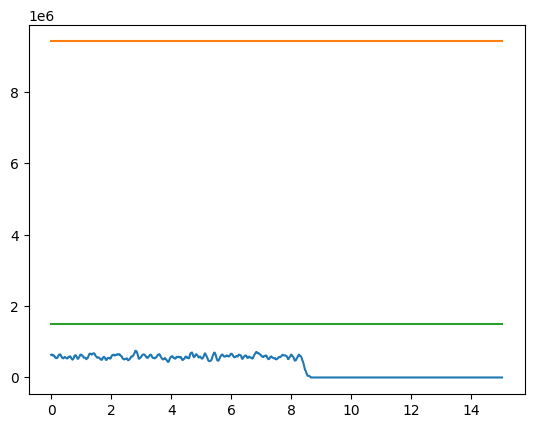

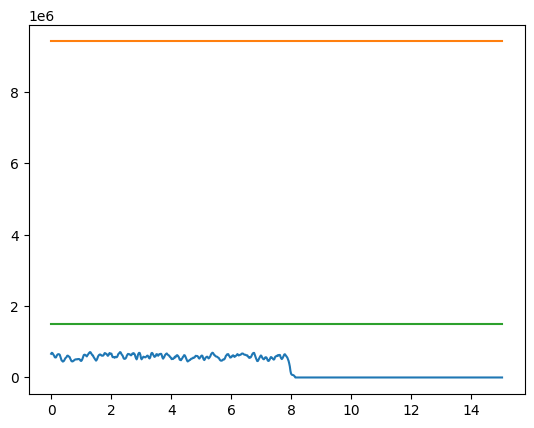

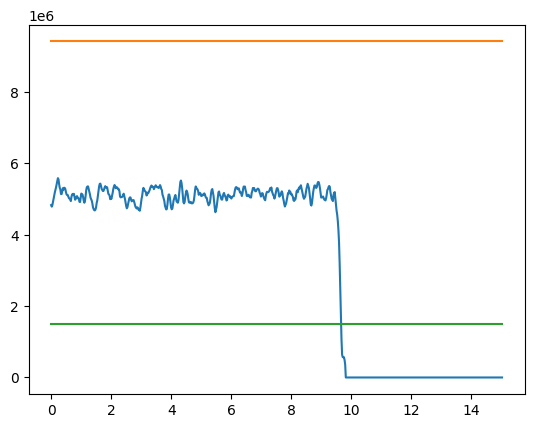

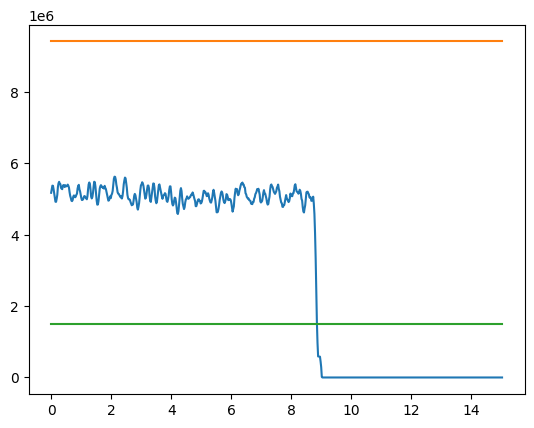

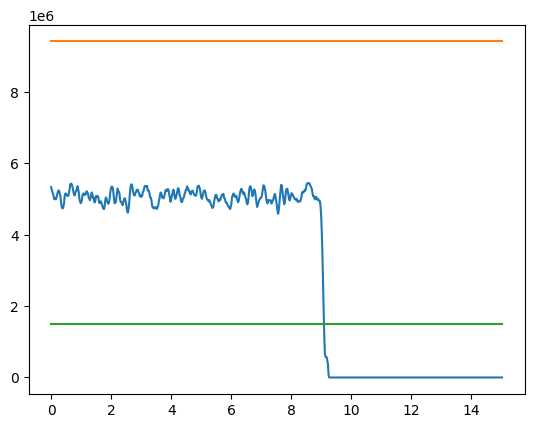

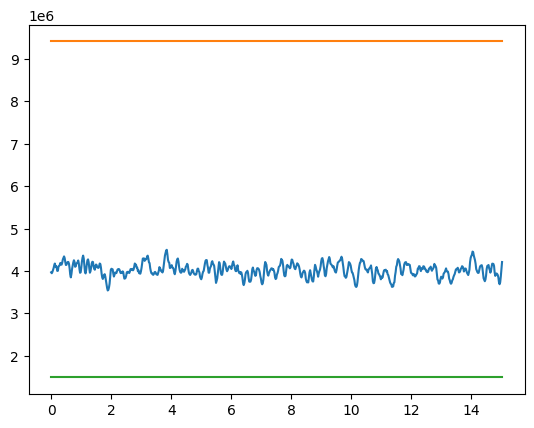

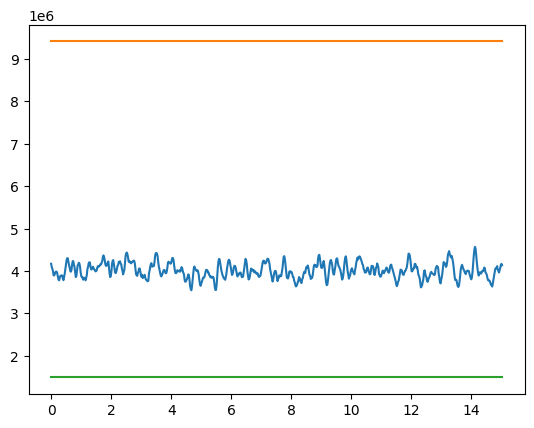

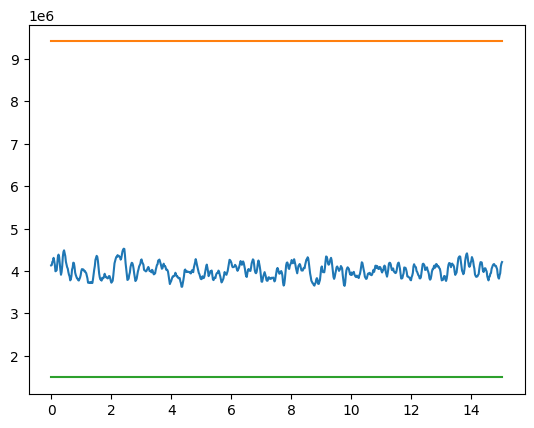

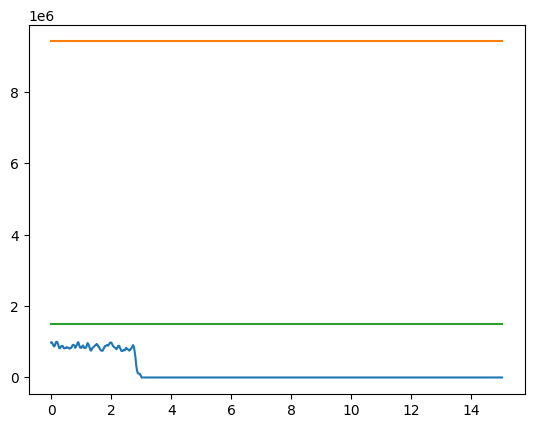

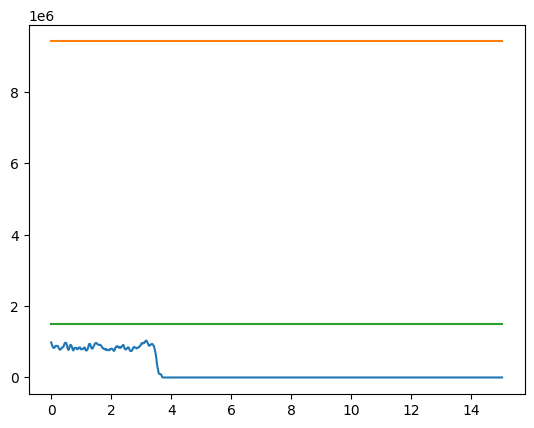

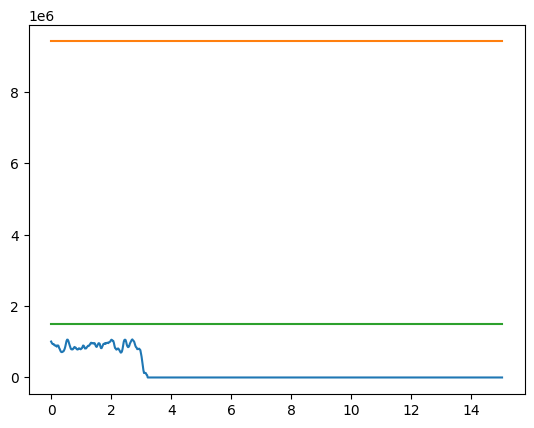

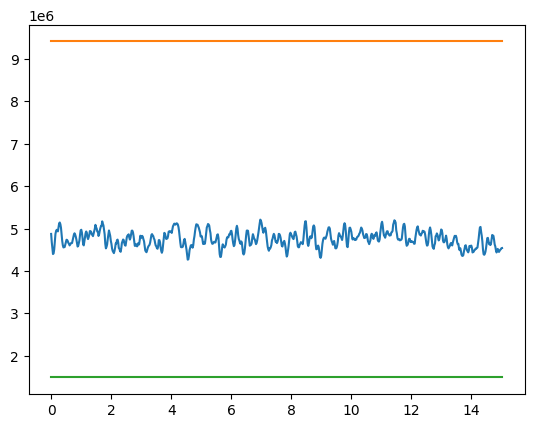

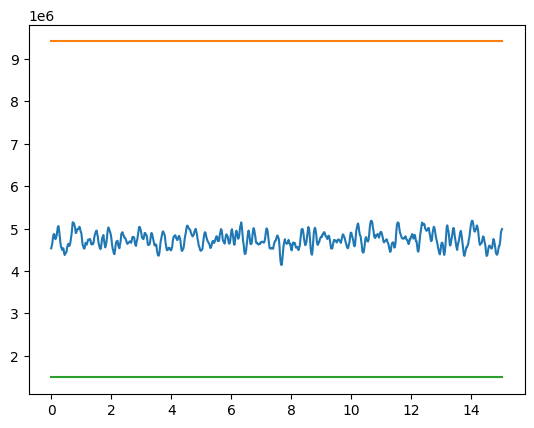

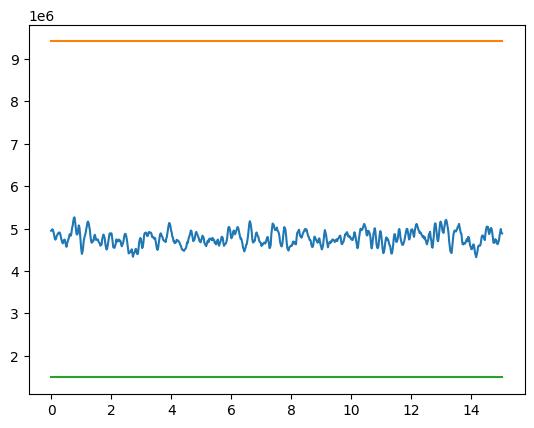

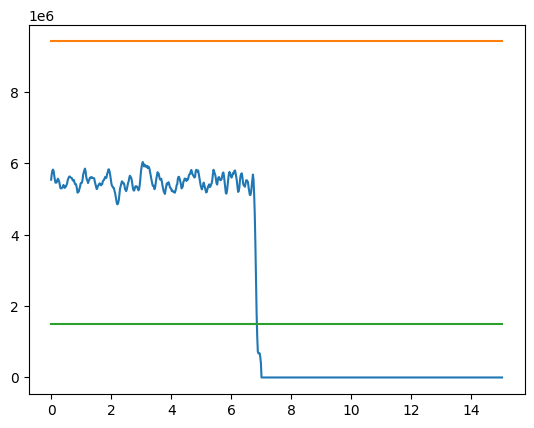

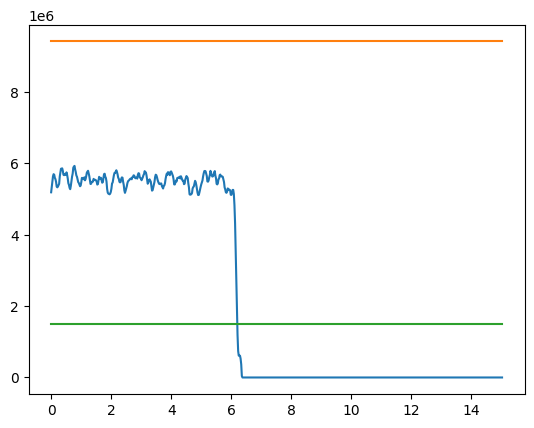

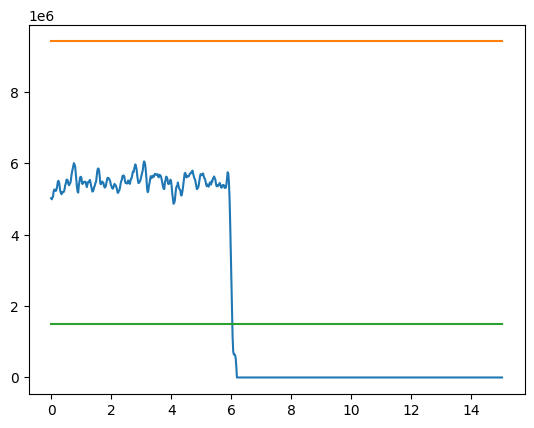

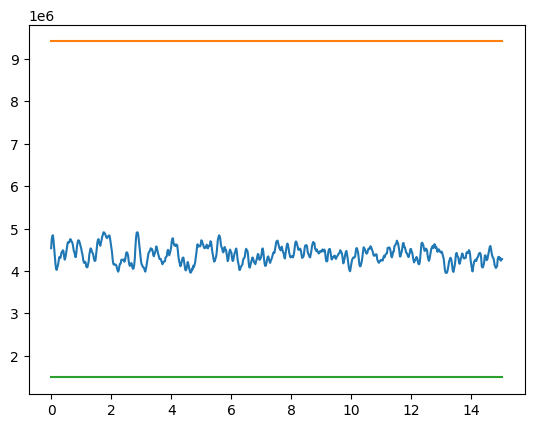

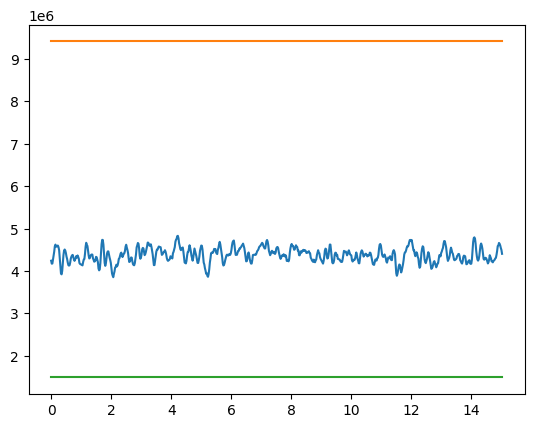

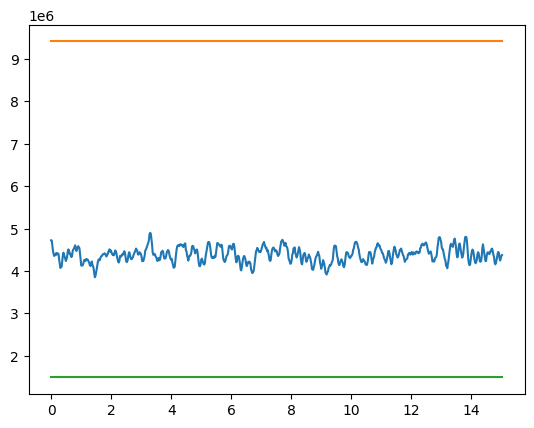

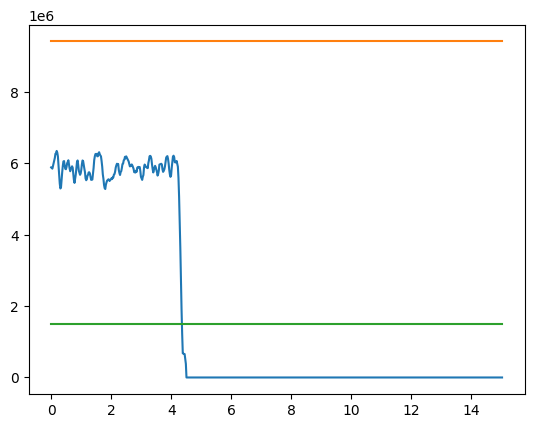

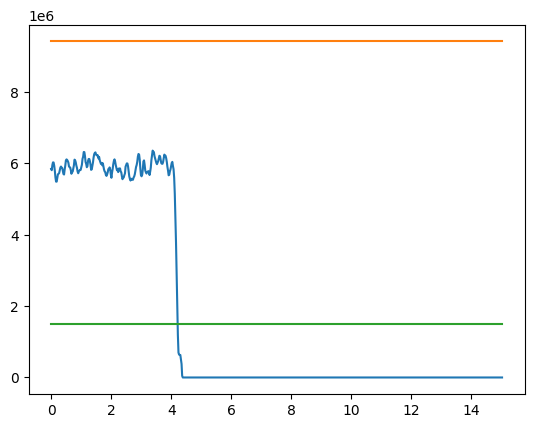

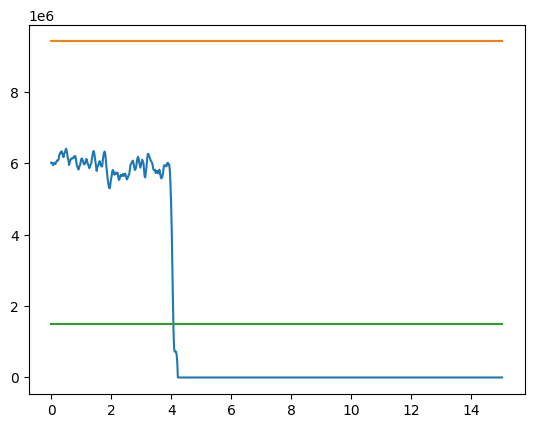

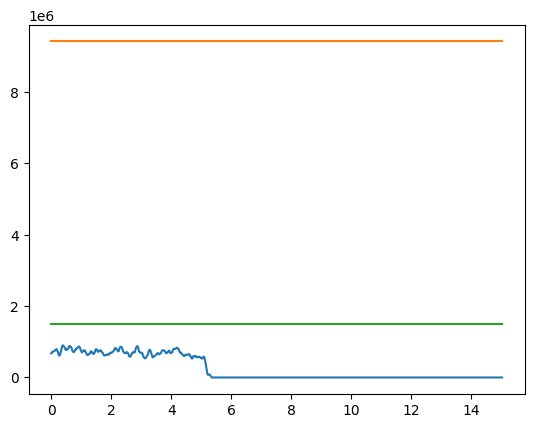

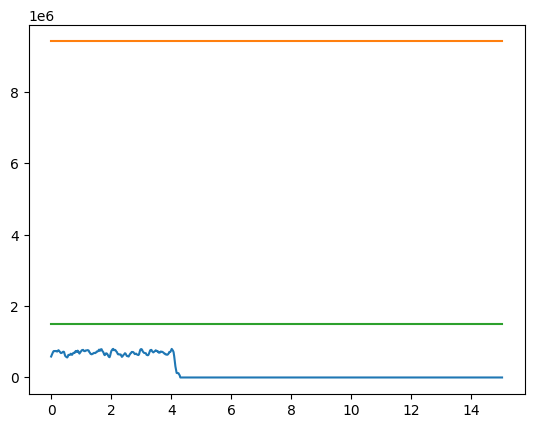

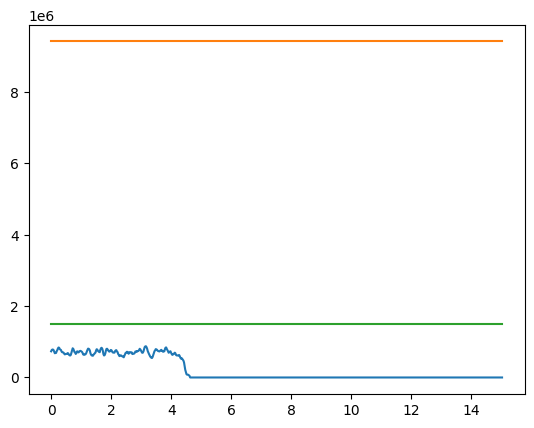

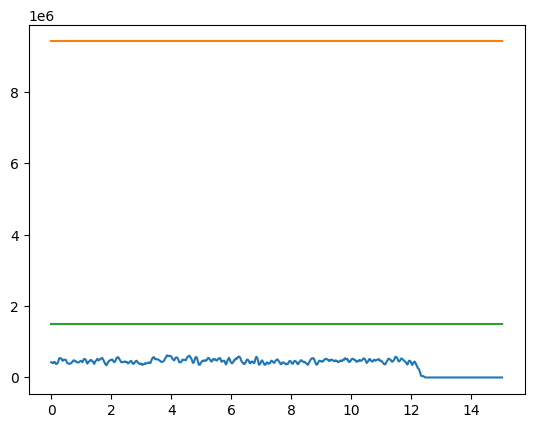

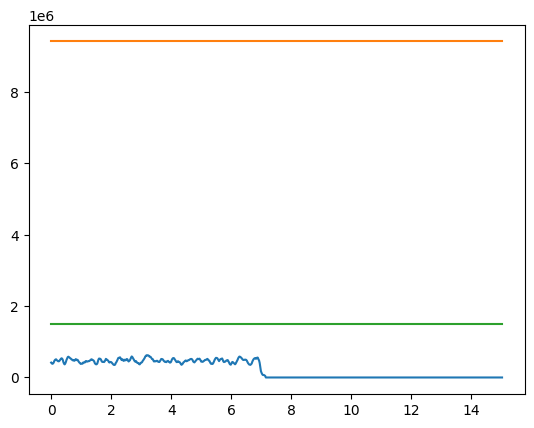

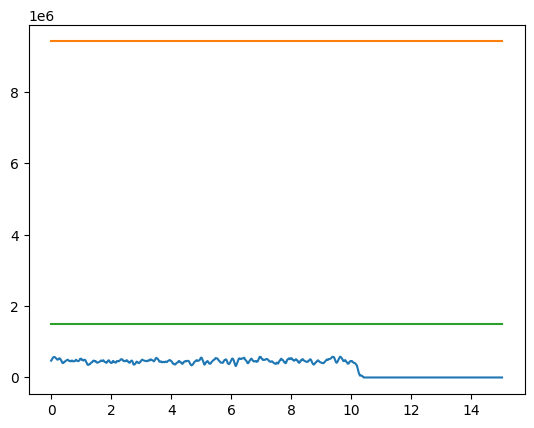

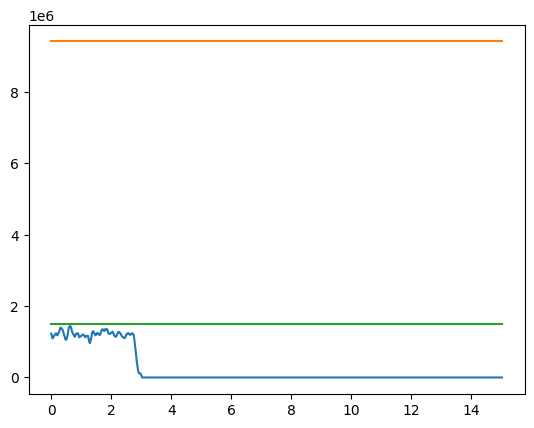

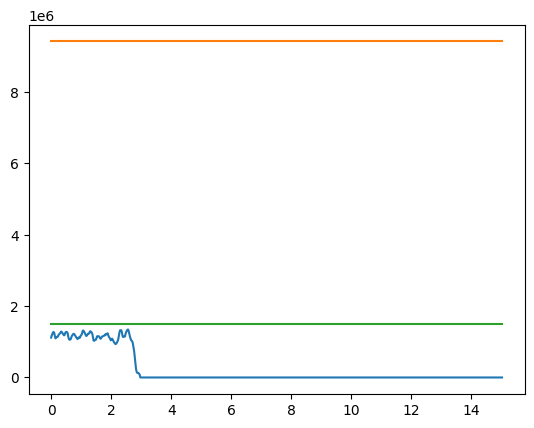

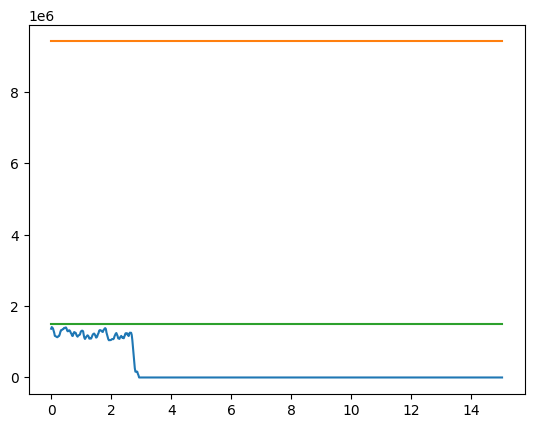

In [21]:
for data in interpolated_datasets:
    xi_list = []
    zeta_list = []
    Y_array = []
    J_array = []
    Y_square_array = []

    for k in range (L, T - N):
        k -= 1
        past_outputs = np.column_stack([data["trolley_position"][k-L:k], data["cable_length"][k-L:k], data["sway_angle"][k-L:k]])
        past_inputs = np.column_stack([data["trolley_motor_pwm"][k-L:k], data["hoist_motor_pwm"][k-L:k]])

        xi = np.column_stack([past_outputs, past_inputs]).reshape(-1, 1)
        xi_list.append(xi)

        future_outputs = np.column_stack([data["trolley_position"][k:k+N], data["cable_length"][k:k+N], data["sway_angle"][k:k+N]])
        future_inputs = np.column_stack([data["trolley_motor_pwm"][k:k+N], data["hoist_motor_pwm"][k:k+N]])

        zeta = np.column_stack([future_outputs, future_inputs]).reshape(-1, 1)
        zeta_list.append(zeta)

        if k > L:
            Y = dissipativity_inequality(P, Phi, xi_list[k-L], xi_list[k-L+1], zeta_list[k-L])
            Y_array.append(Y)
            Y_square_array.append(Y_array[k-L-1]**2)

            if len(Y_square_array) > TF:
                J_array.append(np.sqrt(np.sum(Y_square_array[k-TF-L:k-L])))

    plt.plot(np.linspace(0, DURATION + DT, len(J_array)), np.array(J_array).flatten())
    plt.plot(np.linspace(0, DURATION + DT, len(J_array)), np.linspace(threshold, threshold, len(J_array)))
    plt.plot(np.linspace(0, DURATION + DT, len(J_array)), np.linspace(J_mean, J_mean, len(J_array)))
    plt.show()


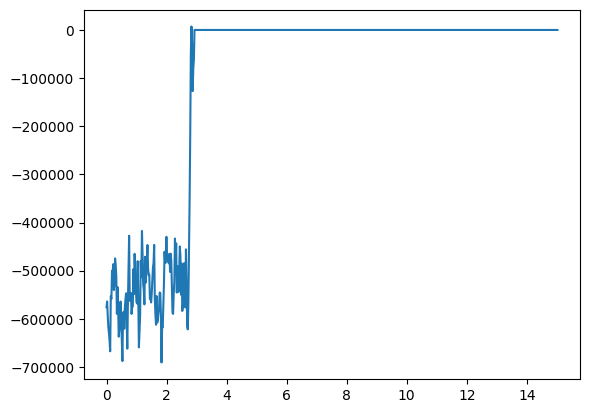

In [22]:
plt.plot(np.linspace(0, DURATION + DT, len(Y_array)), np.array(Y_array).flatten())

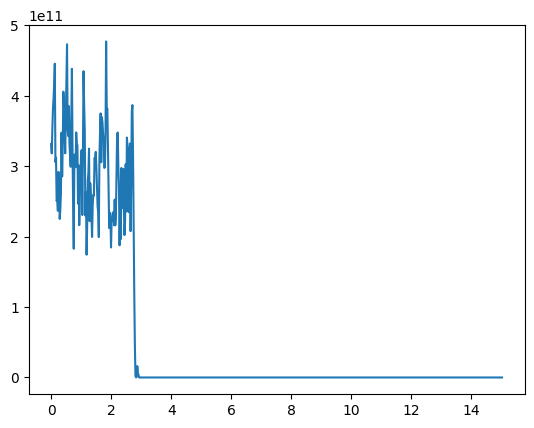

In [23]:
plt.plot(np.linspace(0, DURATION + DT, len(Y_square_array)), np.array(Y_square_array).flatten())